# Image classification from scratch

**Author:** Nitesh Kumar Shah <br>
**Linkedin:** https://www.linkedin.com/nitesh_shah53/ <br>
**Date created:** 2024/03/27<br>
**Description:** Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.

# Reference links -

1. https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
2. https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
3. https://stackoverflow.com/questions/56450969/how-to-calculate-output-sizes-after-a-convolution-layer-in-a-configuration-file
4. https://www.tensorflow.org/api_docs/python/tf/keras/Model


# Dataset Link

1. Credits to :- https://www.kaggle.com/datasets/salader/dogs-vs-cats?select=train

# Setting up Data Directory

In [8]:
!mkdir -p ./kaggle
!cp kaggle.json ~/.kaggle/

In [9]:
!kaggle datasets download -d salader/dogs-vs-cats

100% 1.06G/1.06G [00:09<00:00, 139MB/s]
100% 1.06G/1.06G [00:09<00:00, 116MB/s]


In [10]:
!unzip /content/dogs-vs-cats.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/dogs/dog.4419.jpg  
  inflating: /content/train/dogs/dog.442.jpg  
  inflating: /content/train/dogs/dog.4420.jpg  
  inflating: /content/train/dogs/dog.4421.jpg  
  inflating: /content/train/dogs/dog.4422.jpg  
  inflating: /content/train/dogs/dog.4424.jpg  
  inflating: /content/train/dogs/dog.4425.jpg  
  inflating: /content/train/dogs/dog.4426.jpg  
  inflating: /content/train/dogs/dog.4427.jpg  
  inflating: /content/train/dogs/dog.4431.jpg  
  inflating: /content/train/dogs/dog.4433.jpg  
  inflating: /content/train/dogs/dog.4436.jpg  
  inflating: /content/train/dogs/dog.4438.jpg  
  inflating: /content/train/dogs/dog.4439.jpg  
  inflating: /content/train/dogs/dog.444.jpg  
  inflating: /content/train/dogs/dog.4440.jpg  
  inflating: /content/train/dogs/dog.4441.jpg  
  inflating: /content/train/dogs/dog.4442.jpg  
  inflating: /content/train/dogs/dog.4443.jpg  
  inflating: /content/train/dogs/dog.44

# Installing the required libraries

In [ ]:
!pip3 install tensorflow numpy matplotlib keras

# Importing Packages

In [12]:
import matplotlib.pyplot as plt
from PIL import Image
import random
import os

import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np

# Reading the data

In [ ]:
os.listdir('/content/dogs_vs_cats/train/dogs')

In [ ]:
os.listdir('/content/dogs_vs_cats/train/cats')

In [15]:
random.sample(os.listdir('/content/dogs_vs_cats/train/dogs'), 5)

['dog.9846.jpg',
 'dog.2656.jpg',
 'dog.1603.jpg',
 'dog.2536.jpg',
 'dog.9479.jpg']

In [20]:
os.path.join("/content/dogs_vs_cats/train/cats/", 'cat.0.jpg')

'/content/dogs_vs_cats/train/cats/cat.0.jpg'

In [21]:
def plot_images_from_directory(directory_path, class_animal, num_images=9):
    # Retrieve list of all file names in the directory
    image_filenames = os.listdir(directory_path)

    # If there are fewer images than requested, we'll just show them all
    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    # Randomly select 'num_images' number of file names
    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))  # Adjust the size as needed
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        image = Image.open(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_animal}")
        axes[i].axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()

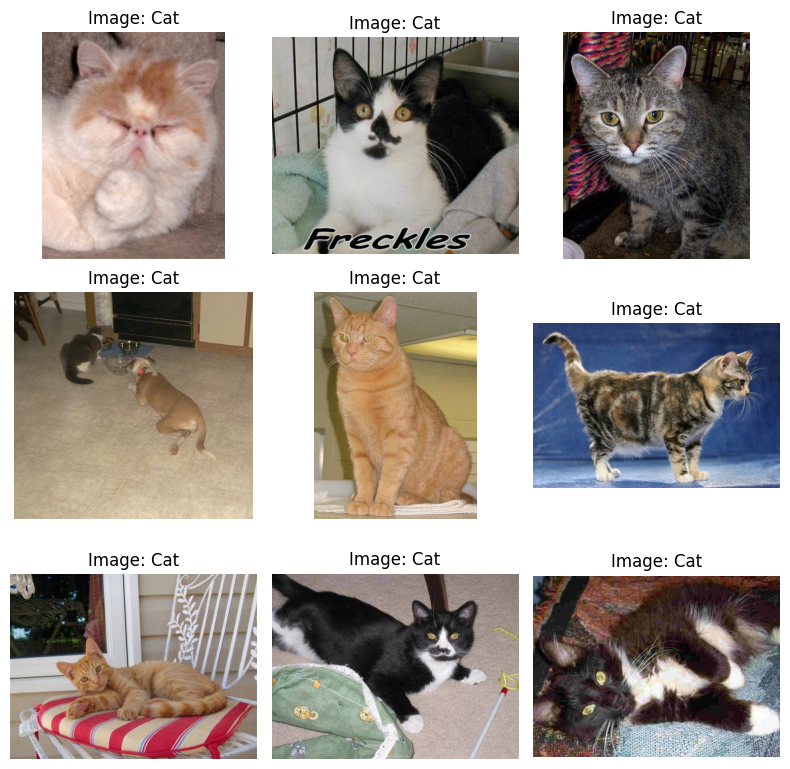

In [22]:
# Placeholder for the directory path
cat_directory_path = '/content/dogs_vs_cats/train/cats'  # Replace with your directory path
plot_images_from_directory(cat_directory_path, class_animal = 'Cat')

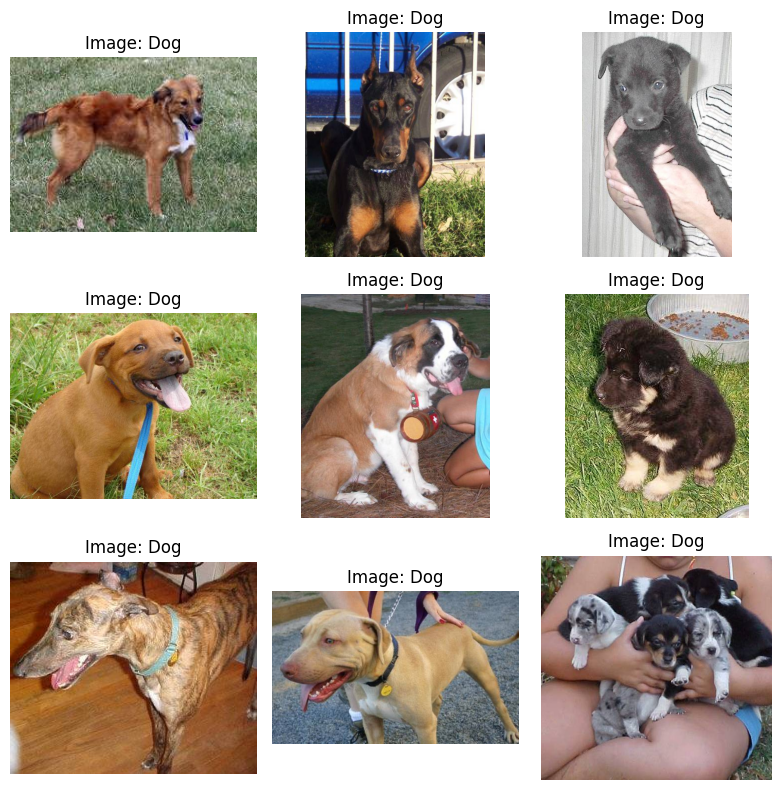

In [23]:
# Placeholder for the directory path
dog_directory_path = '/content/dogs_vs_cats/train/dogs'  # Replace with your directory path
plot_images_from_directory(dog_directory_path, class_animal = 'Dog')

# Data Analysis

In [ ]:
cat_images = os.listdir(cat_directory_path)
dog_images = os.listdir(dog_directory_path)

classes_animals = ['Cats', 'Dogs']
count = [len(cat_images), len(dog_images)]

print(count)

[10000, 10000]


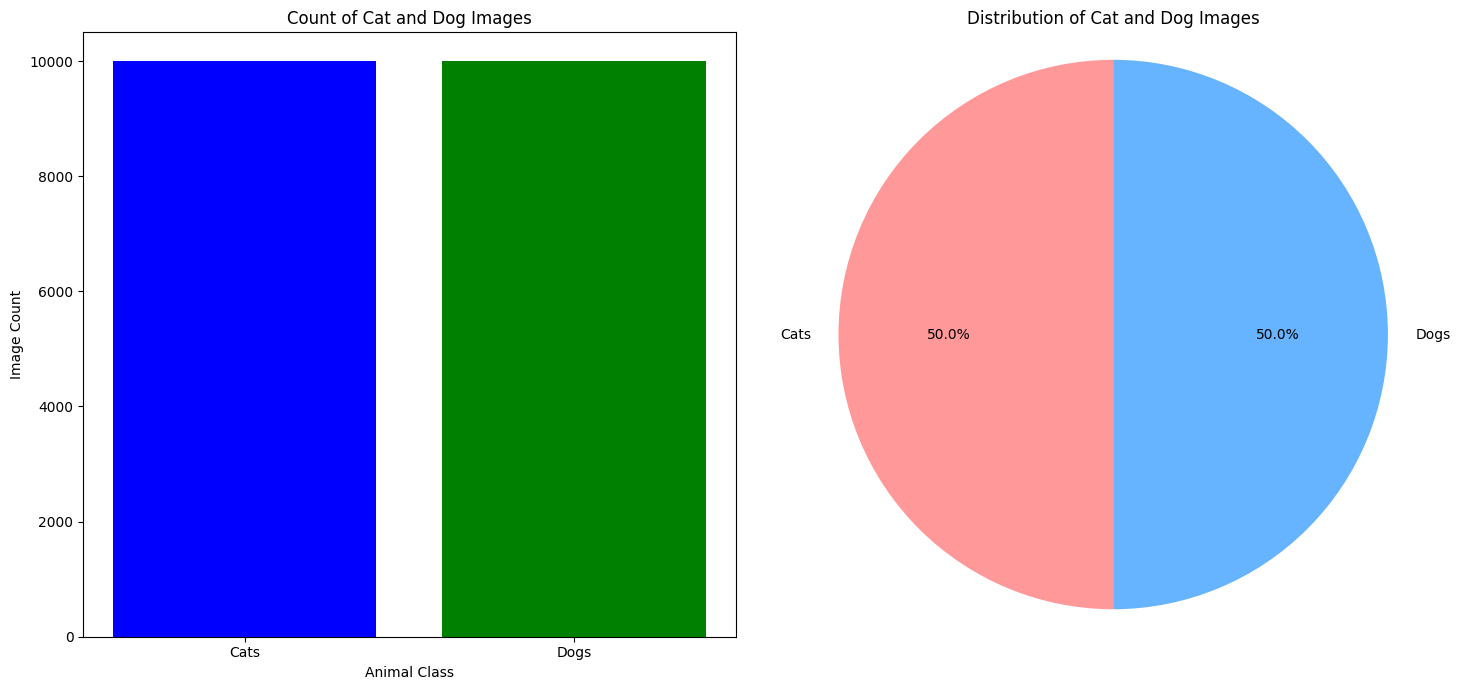

In [ ]:
# Creating both a bar chart and a pie chart side by side in a single figure

# Setting up a figure and axes for two subplots: one for the bar chart, one for the pie chart
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Bar chart on the first subplot
ax[0].bar(classes_animals, count, color=['blue', 'green'])
ax[0].set_xlabel('Animal Class')
ax[0].set_ylabel('Image Count')
ax[0].set_title('Count of Cat and Dog Images')

# Pie chart on the second subplot
colors = ['#ff9999','#66b3ff']
ax[1].pie(count, labels=classes_animals, colors=colors, autopct='%1.1f%%', startangle=90)
ax[1].set_title('Distribution of Cat and Dog Images')
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adjust the layout so that both subplots fit nicely
plt.tight_layout()
plt.show()


# Removing Corrupted Images

In [ ]:
import os
import cv2
import imghdr

# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = '/content/dogs_vs_cats'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
    for file in files:
        # Construct the path to the current file
        file_path = os.path.join(root, file)

        try:
            # Check the file type of the current file
            file_type = imghdr.what(file_path)

            # If the file extension is not in the allowed list, remove it
            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                # Proceed to process the image if needed, for example, reading it with OpenCV
                img = cv2.imread(file_path)

        except Exception as e:
            # Print out the issue and the path of the problematic file
            print(f'Issue with file {file_path}. Error: {e}')
            # Optionally, remove files that cause exceptions
            os.remove(file_path)

# Loading Shapes and Channels

In [ ]:
import numpy as np
from PIL import Image

def image_to_array(image_path):
    """
    Read an image and convert it to a numpy array.

    Parameters:
    image_path (str): The path to the image file.

    Returns:
    np.array: The image as a numpy array.
    """
    try:
        with Image.open(image_path) as img:
            image_array = np.array(img)
            return image_array
    except IOError:
        print(f"Could not read the image file at {image_path}.")
        return None

array([[[  9,   8,   4],
        [ 10,  11,   6],
        [ 13,  13,  11],
        ...,
        [160, 162, 183],
        [159, 161, 184],
        [158, 160, 183]],

       [[ 17,  13,  10],
        [ 16,  15,  11],
        [ 17,  17,  15],
        ...,
        [157, 159, 180],
        [156, 158, 181],
        [155, 157, 180]],

       [[ 17,  12,   8],
        [ 17,  13,  10],
        [ 17,  16,  14],
        ...,
        [155, 157, 178],
        [154, 156, 179],
        [153, 155, 178]],

       ...,

       [[110,  95,  88],
        [111,  96,  89],
        [112,  97,  90],
        ...,
        [128, 111, 101],
        [128, 112,  99],
        [128, 112,  99]],

       [[110,  95,  88],
        [109,  94,  87],
        [110,  95,  88],
        ...,
        [129, 112, 102],
        [129, 113, 100],
        [129, 113, 100]],

       [[113,  98,  91],
        [110,  95,  88],
        [109,  94,  87],
        ...,
        [125, 108,  98],
        [125, 109,  96],
        [125, 109,  96]]], dtype=uint8)
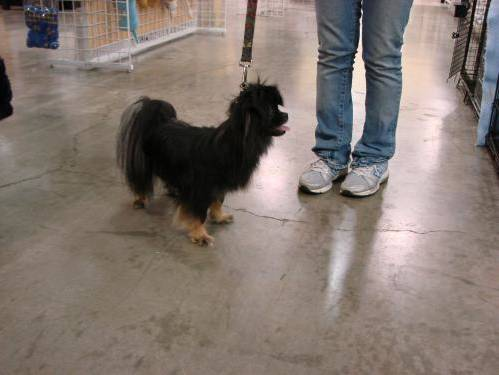

In [ ]:
image_to_array('/content/dogs_vs_cats/train/dogs/dog.1000.jpg')

## Using CV2

In [ ]:
image = '/content/dogs_vs_cats/train/dogs/dog.1000.jpg'

import cv2

img = cv2.imread(image)

# If the image is loaded successfully, print its pixel values
if img is not None:
    print(img)
    print(img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

[[[  4   8   9]
  [  6  11  10]
  [ 11  13  13]
  ...
  [183 162 160]
  [184 161 159]
  [183 160 158]]

 [[ 10  13  17]
  [ 11  15  16]
  [ 15  17  17]
  ...
  [180 159 157]
  [181 158 156]
  [180 157 155]]

 [[  8  12  17]
  [ 10  13  17]
  [ 14  16  17]
  ...
  [178 157 155]
  [179 156 154]
  [178 155 153]]

 ...

 [[ 88  95 110]
  [ 89  96 111]
  [ 90  97 112]
  ...
  [101 111 128]
  [ 99 112 128]
  [ 99 112 128]]

 [[ 88  95 110]
  [ 87  94 109]
  [ 88  95 110]
  ...
  [102 112 129]
  [100 113 129]
  [100 113 129]]

 [[ 91  98 113]
  [ 88  95 110]
  [ 87  94 109]
  ...
  [ 98 108 125]
  [ 96 109 125]
  [ 96 109 125]]]
(375, 499, 3)


## Using python

In [ ]:
# Import necessary libraries
import numpy as np
from PIL import Image


# Load the image with PIL and convert to a NumPy array
img_pil = Image.open(image)
img_array = np.array(img_pil)

# Print the NumPy array of the image
print(img_array)

# Print the NumPy array of the image
print(img_array.shape)

[[[  9   8   4]
  [ 10  11   6]
  [ 13  13  11]
  ...
  [160 162 183]
  [159 161 184]
  [158 160 183]]

 [[ 17  13  10]
  [ 16  15  11]
  [ 17  17  15]
  ...
  [157 159 180]
  [156 158 181]
  [155 157 180]]

 [[ 17  12   8]
  [ 17  13  10]
  [ 17  16  14]
  ...
  [155 157 178]
  [154 156 179]
  [153 155 178]]

 ...

 [[110  95  88]
  [111  96  89]
  [112  97  90]
  ...
  [128 111 101]
  [128 112  99]
  [128 112  99]]

 [[110  95  88]
  [109  94  87]
  [110  95  88]
  ...
  [129 112 102]
  [129 113 100]
  [129 113 100]]

 [[113  98  91]
  [110  95  88]
  [109  94  87]
  ...
  [125 108  98]
  [125 109  96]
  [125 109  96]]]
(375, 499, 3)


In [ ]:
for i,j,k in os.walk('/content/dogs_vs_cats'):
    print(i,j,k)

/content/dogs_vs_cats ['train', 'test'] []
/content/dogs_vs_cats/train ['cats', 'dogs'] []
/content/dogs_vs_cats/train/cats [] ['cat.9164.jpg', 'cat.3788.jpg', 'cat.2514.jpg', 'cat.1981.jpg', 'cat.9346.jpg', 'cat.10588.jpg', 'cat.8311.jpg', 'cat.2945.jpg', 'cat.6832.jpg', 'cat.650.jpg', 'cat.2452.jpg', 'cat.1387.jpg', 'cat.7780.jpg', 'cat.4368.jpg', 'cat.7488.jpg', 'cat.5357.jpg', 'cat.8798.jpg', 'cat.2204.jpg', 'cat.4376.jpg', 'cat.4062.jpg', 'cat.11745.jpg', 'cat.1104.jpg', 'cat.378.jpg', 'cat.2375.jpg', 'cat.5158.jpg', 'cat.7039.jpg', 'cat.9961.jpg', 'cat.12045.jpg', 'cat.2179.jpg', 'cat.10326.jpg', 'cat.1964.jpg', 'cat.6571.jpg', 'cat.7305.jpg', 'cat.7854.jpg', 'cat.335.jpg', 'cat.10365.jpg', 'cat.8058.jpg', 'cat.10951.jpg', 'cat.8212.jpg', 'cat.6100.jpg', 'cat.11036.jpg', 'cat.3616.jpg', 'cat.6271.jpg', 'cat.9498.jpg', 'cat.494.jpg', 'cat.421.jpg', 'cat.4537.jpg', 'cat.1853.jpg', 'cat.9752.jpg', 'cat.8834.jpg', 'cat.10572.jpg', 'cat.7468.jpg', 'cat.10867.jpg', 'cat.10313.jpg', 'ca

In [ ]:
!pip3 install opencv-python

# Building Model

In [ ]:
# Set path to the dataset
base_dir = '/content/dogs_vs_cats/train'

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [ ]:
 # Using 20% of data for validation
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),  # Resizing images to 150x150
    batch_size=20,
    class_mode='binary',  # Since we use binary_crossentropy loss, we need binary labels
    subset='training')  # Set as training data

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    subset='validation')  # Set as validation data

Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


# Getting Class Labels

In [ ]:
# Accessing class labels for the training data
train_class_labels = train_generator.class_indices
print("Training class labels:", train_class_labels)

# Accessing class labels for the validation data
validation_class_labels = validation_generator.class_indices
print("Validation class labels:", validation_class_labels)

Training class labels: {'cats': 0, 'dogs': 1}
Validation class labels: {'cats': 0, 'dogs': 1}


# visualising the Batch Images

In [ ]:
images, labels = next(train_generator)
images, labels

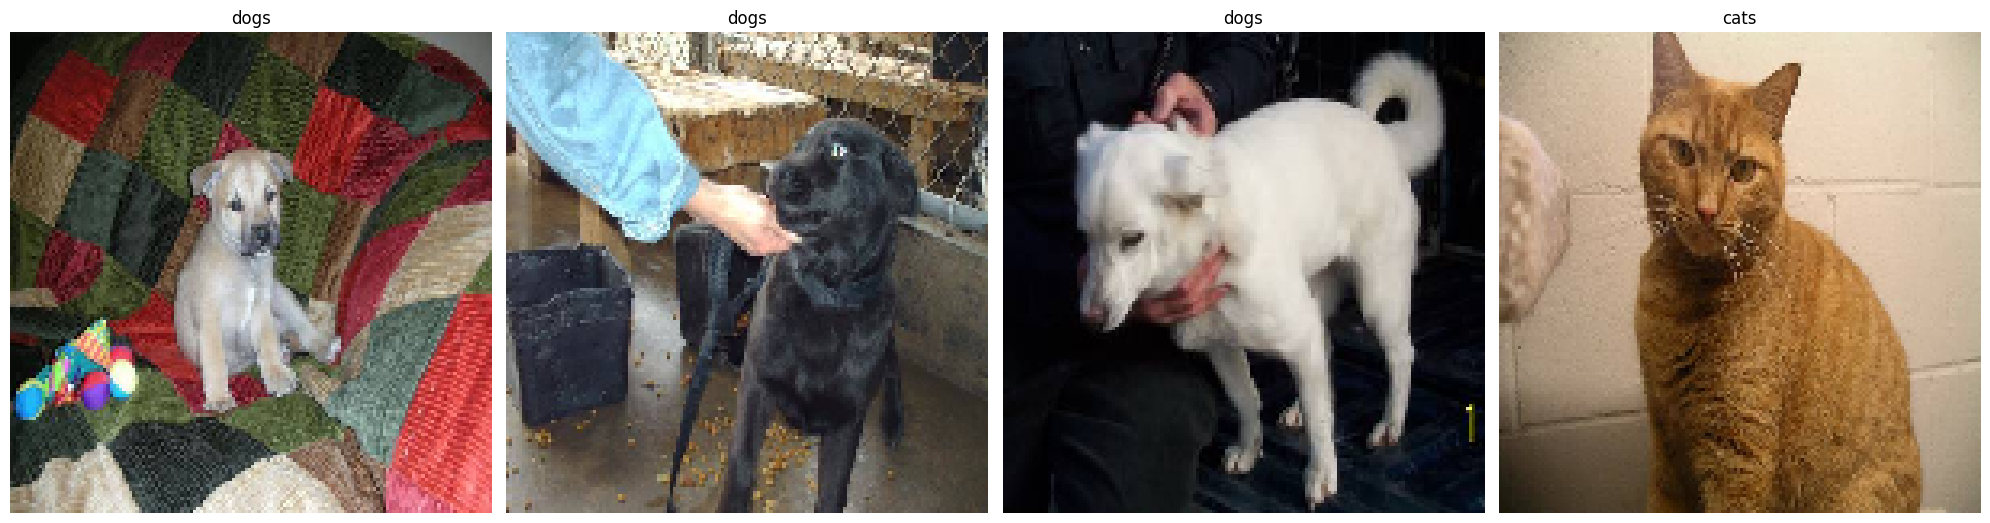

In [ ]:
import matplotlib.pyplot as plt

# Function to plot images and their labels
def plot_images_from_generator(generator, num_images=4):
    # Get a batch of images and labels from the generator
    images, labels = next(generator)

    # Set up the plot
    fig, axes = plt.subplots(1, num_images, figsize=(20,20))
    axes = axes.flatten()

    for img, label, ax in zip(images, labels, axes):
        # Image preprocessing might differ, adjust accordingly
        ax.imshow(img)
        # Set the title to the class label
        # Inverse the class indices dictionary to get class names from labels
        class_labels = dict((v,k) for k,v in generator.class_indices.items())
        ax.set_title(class_labels[int(label)])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Now, call this function with your training generator
plot_images_from_generator(train_generator, num_images=4)

In [ ]:
train_generator.reset()

# Basic CNN Model

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

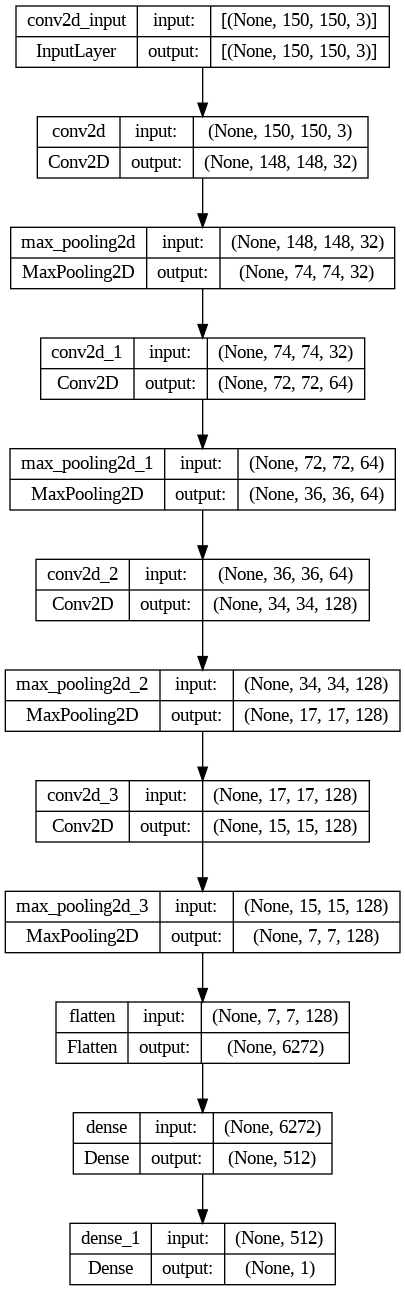

In [ ]:
plot_model(model, to_file = 'Architecture.png',
           show_shapes=True, show_layer_names=True)

## Parameter Calculation in CNN Layers

### Conv2D Layer

The formula to calculate the number of parameters in a Conv2D layer is:

$$\text{Parameters} = (\text{kernel\_height} \times \text{kernel\_width} \times \text{input\_channels} + 1) \times \text{number\_of\_filters}$$

The "+1" accounts for the bias term for each filter.

#### 1. First Conv2D Layer

- Input shape: (150, 150, 3)
- Number of filters: 32
- Filter size: (3, 3)
- Parameters: $$(3 \times 3 \times 3 + 1) \times 32 = 896$$

#### 2. Second Conv2D Layer

- Input channels: 32 (from the previous Conv2D layer)
- Number of filters: 64
- Filter size: (3, 3)
- Parameters: $$(3 \times 3 \times 32 + 1) \times 64 = 18,496$$

#### 3. Third Conv2D Layer

- Input channels: 64
- Number of filters: 128
- Filter size: (3, 3)
- Parameters: $$(3 \times 3 \times 64 + 1) \times 128 = 73,856$$

#### 4. Fourth Conv2D Layer

- Input channels: 128
- Number of filters: 128
- Filter size: (3, 3)
- Parameters: $$(3 \times 3 \times 128 + 1) \times 128 = 147,584$$

### MaxPooling2D Layer

MaxPooling layers do not have parameters; they only reduce the size of the input they're applied to, based on their pool size and stride.

### Flatten Layer

The Flatten layer itself doesn't have parameters. It simply reshapes the input but does not affect the total parameter count.

### Dense Layer

The formula for a Dense (fully connected) layer is:

$$\text{Parameters} = (\text{input\_size} + 1) \times \text{output\_size}$$

#### 1. First Dense Layer

- Assuming Flatten output size: X (you'll need to calculate this based on the output of the last pooling layer).
- Output size: 512
- Parameters: $$(X + 1) \times 512$$

#### 2. Second Dense Layer

- Input size: 512
- Output size: 1 (for binary classification)
- Parameters: $$(512 + 1) \times 1 = 513$$


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
batch = 20
train_steps = np.ceil(train_generator.samples / batch)
validation_steps_per_epoch = np.ceil(validation_generator.samples / batch)
print(train_steps, validation_steps_per_epoch)

800.0 200.0


In [ ]:
history = model.fit(
                    train_generator,
                    steps_per_epoch=800,
                    epochs=10,
                    validation_data=validation_generator,
                    validation_steps=200)

Epoch 1/10
800/800 [==============================] - 41s 44ms/step - loss: 0.6797 - accuracy: 0.5529 - val_loss: 0.6337 - val_accuracy: 0.6453
Epoch 2/10
800/800 [==============================] - 36s 45ms/step - loss: 0.5543 - accuracy: 0.7144 - val_loss: 0.4807 - val_accuracy: 0.7697
Epoch 3/10
800/800 [==============================] - 34s 42ms/step - loss: 0.4374 - accuracy: 0.7920 - val_loss: 0.4153 - val_accuracy: 0.8175
Epoch 4/10
800/800 [==============================] - 35s 44ms/step - loss: 0.3636 - accuracy: 0.8404 - val_loss: 0.3906 - val_accuracy: 0.8260
Epoch 5/10
800/800 [==============================] - 35s 43ms/step - loss: 0.2877 - accuracy: 0.8782 - val_loss: 0.3396 - val_accuracy: 0.8497
Epoch 6/10
800/800 [==============================] - 35s 44ms/step - loss: 0.2229 - accuracy: 0.9072 - val_loss: 0.3467 - val_accuracy: 0.8522
Epoch 7/10
800/800 [==============================] - 39s 48ms/step - loss: 0.1598 - accuracy: 0.9321 - val_loss: 0.3746 - val_accuracy:

In [ ]:
history

In [ ]:
history.history

{'loss': [0.6797187328338623,
  0.5543175339698792,
  0.43741530179977417,
  0.36362355947494507,
  0.2876889705657959,
  0.22291450202465057,
  0.15983712673187256,
  0.10849880427122116,
  0.07186832278966904,
  0.056198809295892715],
 'accuracy': [0.5528749823570251,
  0.7143750190734863,
  0.7919999957084656,
  0.8404374718666077,
  0.8781874775886536,
  0.9071875214576721,
  0.9321249723434448,
  0.9569374918937683,
  0.9738749861717224,
  0.9789375066757202],
 'val_loss': [0.6337449550628662,
  0.4806709587574005,
  0.41533613204956055,
  0.3905603885650635,
  0.33963173627853394,
  0.3467380404472351,
  0.37455615401268005,
  0.4965898096561432,
  0.4933255910873413,
  0.5651592016220093],
 'val_accuracy': [0.6452500224113464,
  0.7697499990463257,
  0.8174999952316284,
  0.8259999752044678,
  0.8497499823570251,
  0.8522499799728394,
  0.8629999756813049,
  0.8552500009536743,
  0.859250009059906,
  0.8529999852180481]}

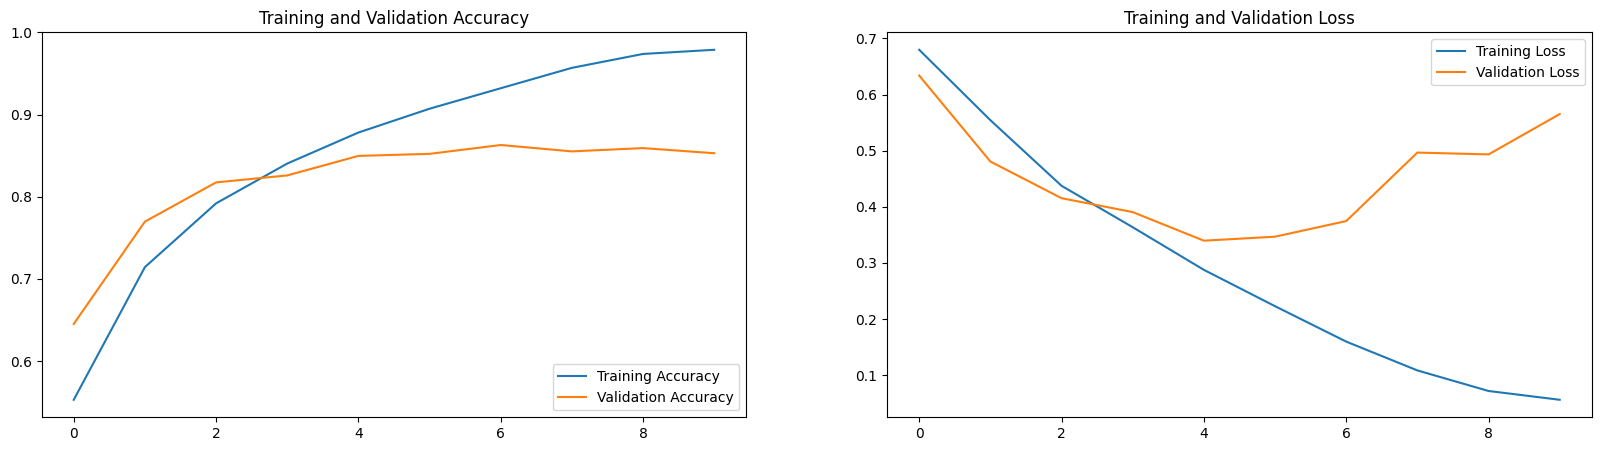

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model Evluation


## Initiating Test Generator

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for test data

test_dir = '/content/dogs_vs_cats/test'  # Path to your test directory

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),  # Should match the input size of your network
    batch_size=20,  # Can adjust based on your memory constraints
    class_mode='binary',  # Since we use binary_crossentropy loss, we need binary labels
    shuffle=False)  # No need to shuffle test data

Found 5000 images belonging to 2 classes.


## Making test predictions

In [ ]:
np.ceil(test_generator.samples/test_generator.batch_size)

250.0

In [ ]:
probabilities = model.predict(test_generator,
                              steps=np.ceil(test_generator.samples/test_generator.batch_size))
probabilities

250/250 [==============================] - 9s 32ms/step


array([[1.6222133e-11],
       [3.6358374e-09],
       [1.6519446e-06],
       ...,
       [7.9404515e-01],
       [4.7007200e-01],
       [9.9572819e-01]], dtype=float32)

In [ ]:
# Reset the test generator
test_generator.reset()

# Get the true labels
true_classes = test_generator.classes

# Predict probabilities for the positive class
probabilities = model.predict(test_generator,
                              steps=np.ceil(test_generator.samples/test_generator.batch_size))

# The output is the probability of the positive class,
# so we will threshold it at 0.5 to decide the predicted class
predicted_classes = (probabilities > 0.5).astype(int).squeeze()


# Class labels are just [0, 1] for binary classification, or you can use custom labels if you have them
class_labels = list(test_generator.class_indices.keys())
predicted_classes

250/250 [==============================] - 10s 39ms/step


array([0, 0, 0, ..., 1, 0, 1])

## Plotting confusion Matrix

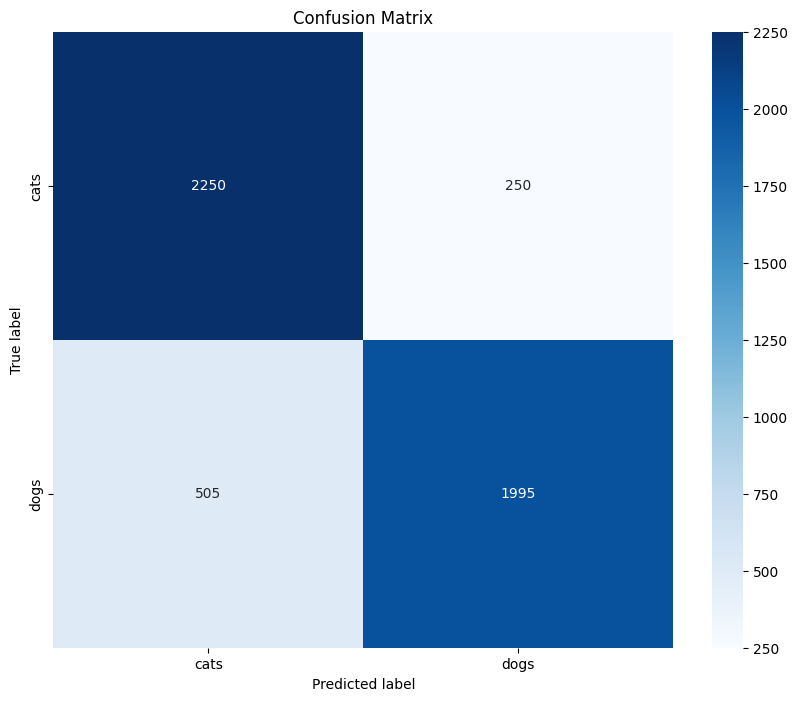

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Inference

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {accuracy*100:.2f}%")
print(f"Test loss: {loss:.2f}")

250/250 [==============================] - 9s 37ms/step - loss: 0.5384 - accuracy: 0.8684
Test accuracy: 86.84%
Test loss: 0.54


# Single Image Prediction

In [ ]:
def make_prediction(image_path):
    img = load_img(img_path, target_size=(150, 150))  # Resizing the image
    img_array = img_to_array(img)  # Converting to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.  # Rescale the image similarly as we did for the training data

    prediction = model.predict(img_array)
    print("Prediction:", prediction)

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    # Prediction
    plt.subplot(1, 2, 2)
    if prediction[0][0] > 0.5:
        plt.title('Predicted: Dog')
    else:
        plt.title('Predicted: Cat')
    plt.imshow(img)  # Show the same image as prediction
    plt.axis('off')

    plt.show()

1/1 [==============================] - 1s 511ms/step
Prediction: [[7.686156e-06]]


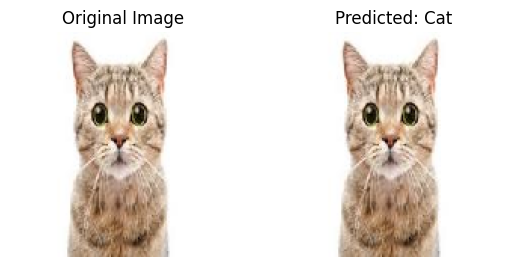

In [ ]:
# Load and preprocess the image
img_path = '/content/download.jpeg'
make_prediction(img_path)

1/1 [==============================] - 0s 25ms/step
Prediction: [[0.44657654]]


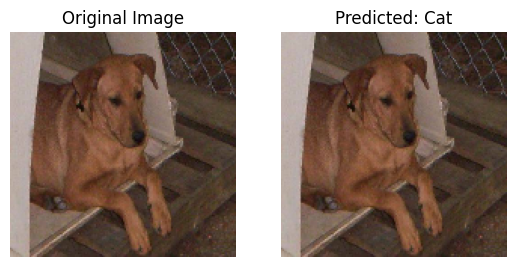

In [ ]:
# Load and preprocess the image
img_path = '/content/dogs_vs_cats/test/dogs/dog.100.jpg'
make_prediction(img_path)

# MisClassifcaitons

In [ ]:
# Reset the test_generator before making predictions
test_generator.reset()

# Predict the whole test set
predictions = model.predict(test_generator, verbose=1)

# The predictions will be in the format of probabilities. You'll need to convert these to binary labels (0 or 1) based on a 0.5 threshold.
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)
true_classes = test_generator.classes
misclassified_indices = np.where(predicted_classes != true_classes)[0]
misclassified_count = len(misclassified_indices)
print(f"Total misclassifications in the test set: {misclassified_count} out of {len(true_classes)}")

250/250 [==============================] - 8s 31ms/step
Total misclassifications in the test set: 755 out of 5000


250/250 [==============================] - 9s 37ms/step
Total misclassifications: 755


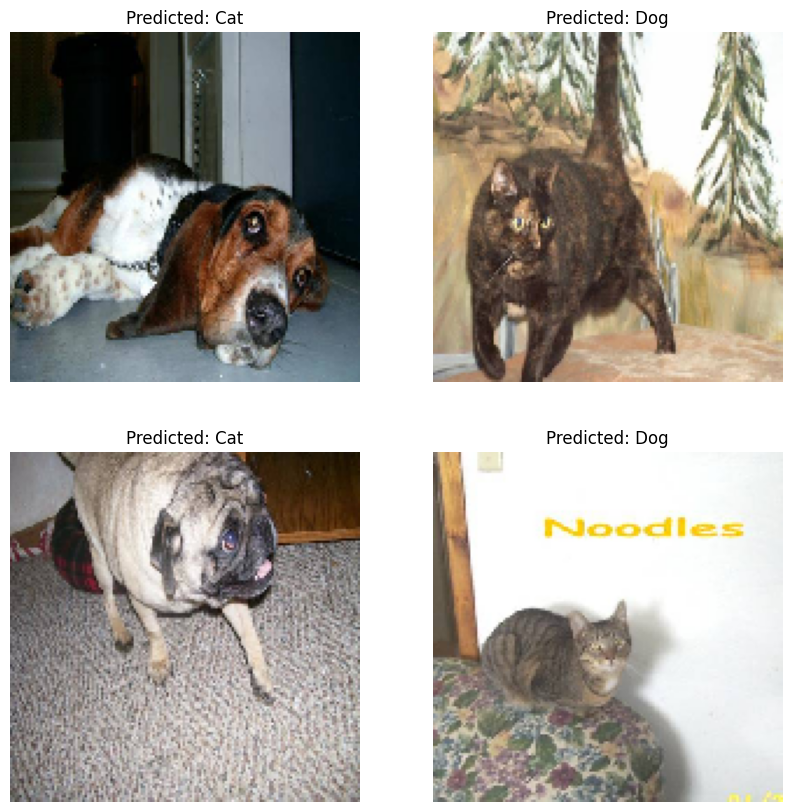

In [ ]:
# Generate predictions for all test images
predictions = model.predict(test_generator)
# Convert predictions to binary (0 or 1) based on a 0.5 threshold
predicted_classes = predictions > 0.5

# Retrieve the true labels from the generator
true_classes = test_generator.classes

# Filenames can also be useful for debugging
filenames = test_generator.filenames
# Identifying indices of misclassified images
misclassified_indices = np.where(predicted_classes.flatten() != true_classes)[0]

print(f"Total misclassifications: {len(misclassified_indices)}")


# Select a random subset of misclassified images
num_samples_to_display = 4
random_indices = random.sample(list(misclassified_indices), num_samples_to_display)

# Plot
plt.figure(figsize=(10, 10))
for i, index in enumerate(random_indices, 1):
    # Load image
    img_path = test_dir + '/' + filenames[index]
    img = load_img(img_path, target_size=(150, 150))

    # Predicted class
    predicted_class = "Dog" if predicted_classes[index] else "Cat"

    # Display
    plt.subplot(2, 2, i)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
plt.show()

# Visualising the kernel feature maps.

In [ ]:
# Get all the layers in which conv is present.

for i in range(len(model.layers)):
	# check for convolutional layer
	if 'conv' not in model.layers[i].name:
		continue
	# get filter weights
	filters, biases = model.layers[i].get_weights()
	print("layer number",i,model.layers[i].name, filters.shape)

layer number 0 conv2d (3, 3, 3, 32)
layer number 2 conv2d_1 (3, 3, 32, 64)
layer number 4 conv2d_2 (3, 3, 64, 128)
layer number 6 conv2d_3 (3, 3, 128, 128)


In [ ]:
# retrieve weights from the second hidden layer
filters , bias = model.layers[2].get_weights()

In [ ]:
filters.shape, bias.shape

((3, 3, 32, 64), (64,))

In [ ]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

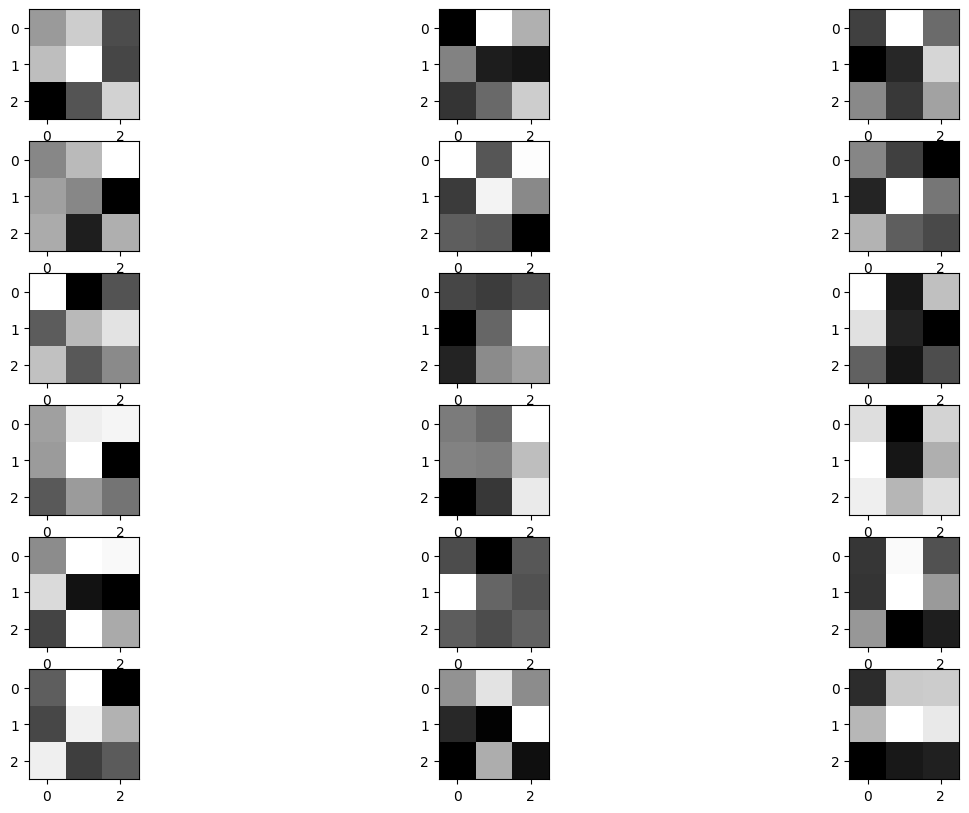

In [ ]:
n_filters=6
ix=1
fig = plt.figure(figsize=(15,10))
for i in range(n_filters):
    # get the filters
    f = filters[:,:,:,i]
    for j in range(3):
        # subplot for 6 filters and 3 channels
        plt.subplot(n_filters,3,ix)
        plt.imshow(f[:,:,j] ,cmap='gray')
        ix+=1
#plot the filters
plt.show()

1/1 [==============================] - 0s 47ms/step


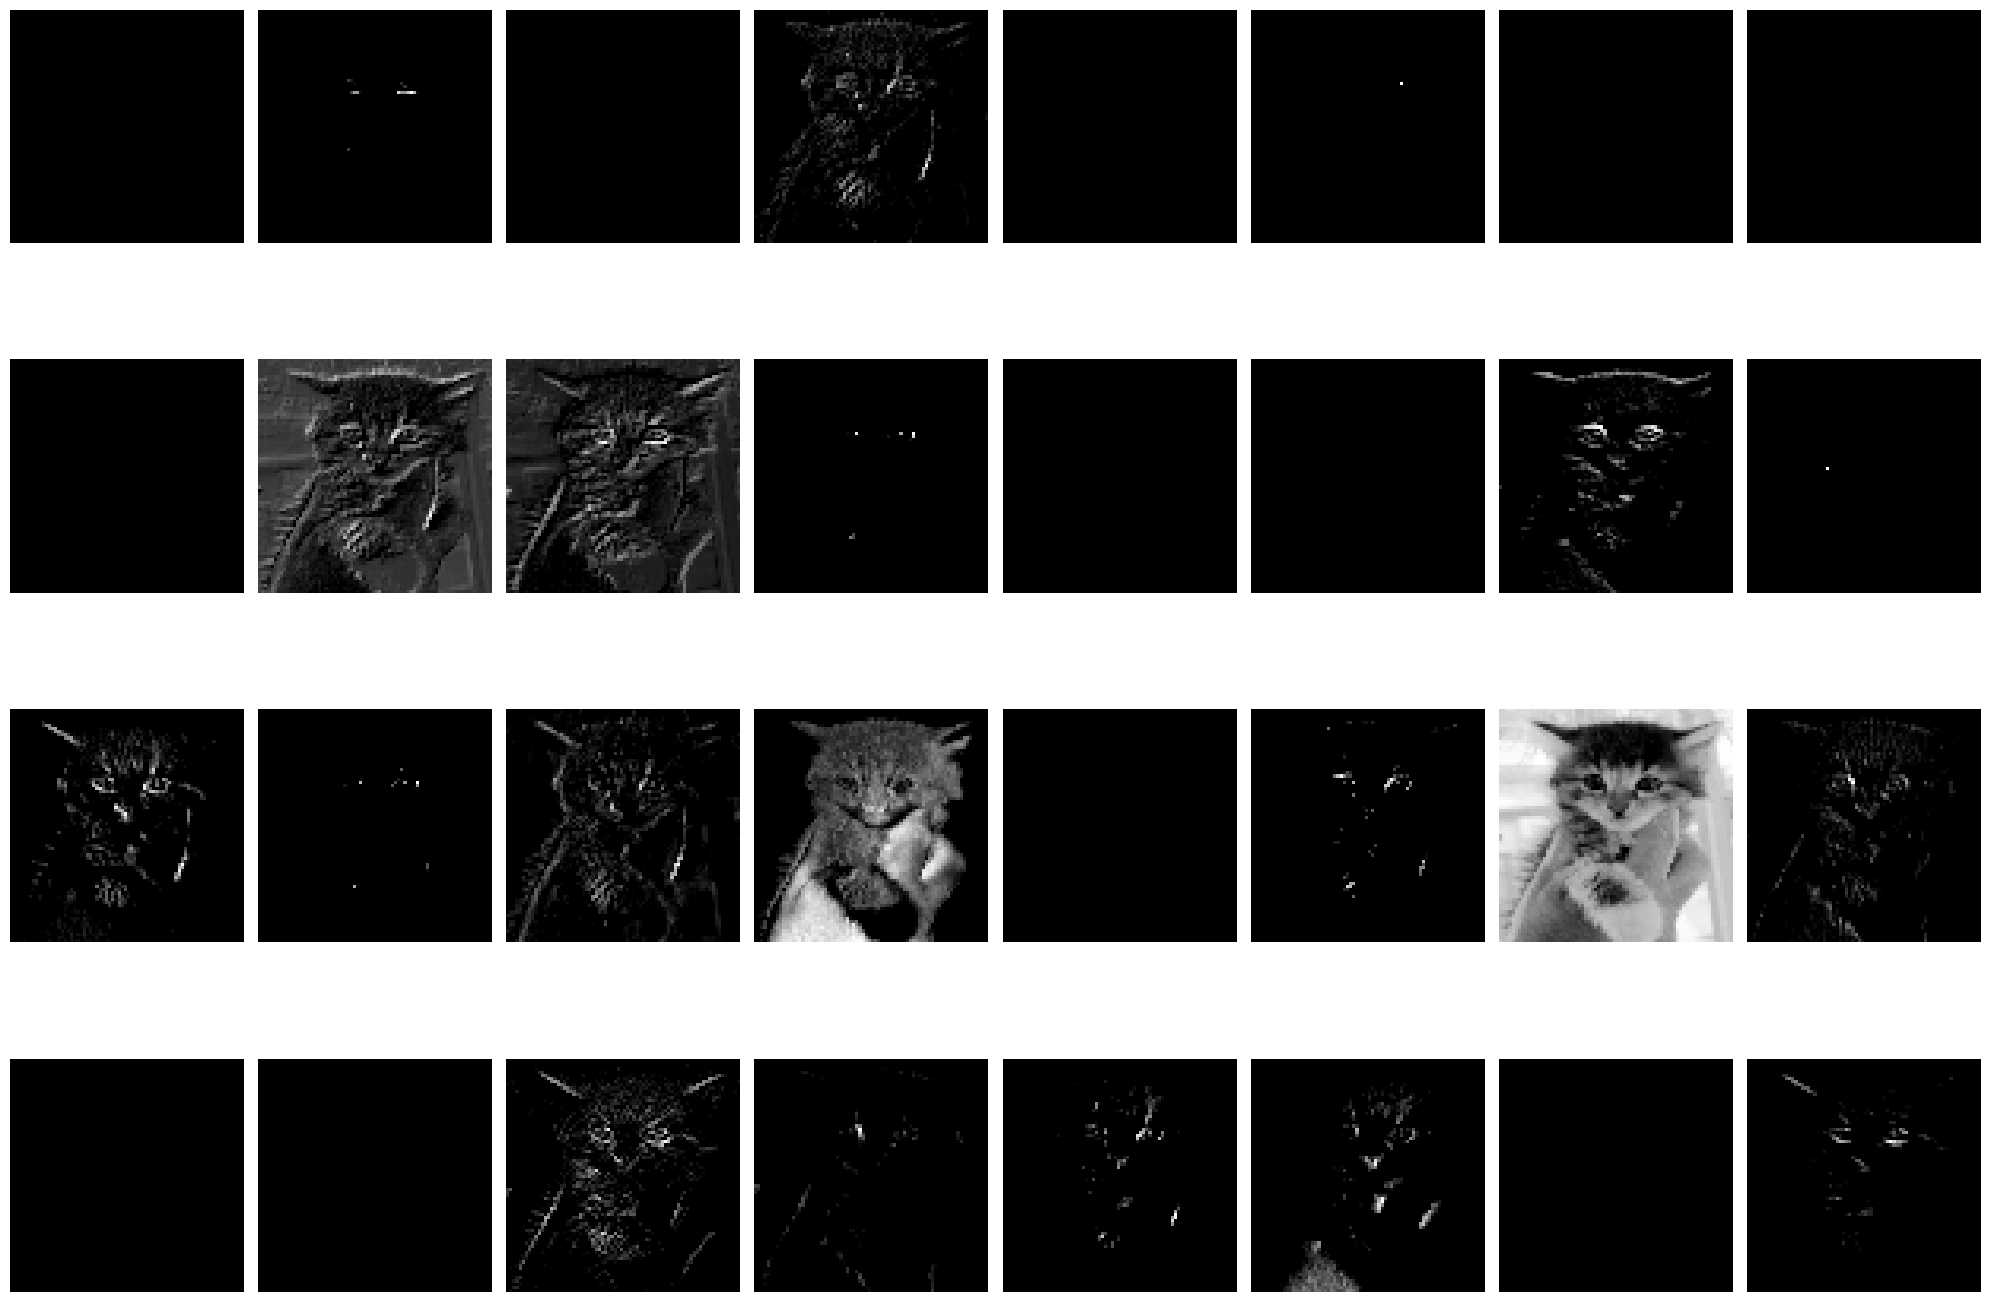

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

# Assuming 'model' is your pre-trained CNN model
model2 = tf.keras.Model(inputs=model.inputs, outputs=model.layers[1].output)

# Load and preprocess the image
image = load_img("/content/dogs_vs_cats/train/cats/cat.100.jpg", target_size=(150, 150))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image /= 255.0

# Predicting using model2 to get the features from the desired layer
features = model2.predict(image)

# Calculate the number of grids dynamically
num_feature_maps = features.shape[-1]
num_cols = 8  # You can adjust this number based on your preference
num_rows = num_feature_maps // num_cols + (1 if num_feature_maps % num_cols else 0)

fig = plt.figure(figsize=(20, 15))
for i in range(1, num_feature_maps + 1):
    ax = fig.add_subplot(num_rows, num_cols, i)
    ax.imshow(features[0, :, :, i-1], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()